# IMPORTS

## LIBRARIES

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split, RandomizedSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.preprocessing import RobustScaler, MinMaxScaler

from sklearn.metrics import mean_squared_error, mean_absolute_error

from boruta import BorutaPy
import xgboost as xgb

# DATA EXTRACTION

## Data Fields Description

**longitude**: A measure of how far west a house is; a higher value is farther west

**latitude**: A measure of how far north a house is; a higher value is farther north

**housingMedianAge**: Median age of a house within a block; a lower number is a newer building

**totalRooms**: Total number of rooms within a block

**totalBedrooms**: Total number of bedrooms within a block

**population**: Total number of people residing within a block

**households**: Total number of households, a group of people residing within a home unit, for a block

**medianIncome**: Median income for households within a block of houses (measured in tens of thousands of US Dollars)

**medianHouseValue**: Median house value for households within a block (measured in US Dollars)

**oceanProximity**: Location of the house w.r.t ocean/sea

## Data Loading

In [2]:
df_raw = pd.read_csv('../data/housing.csv')

# DATA DESCRIPTION

In [3]:
df1 = df_raw.copy()
df1 = df1.dropna()

## Descriptive Data Analysis

In [4]:
num_attributes = df1.select_dtypes(include='float64')
num_attributes.describe().T

,count,mean,std,min,25%,50%,75%,max
longitude,20433.0,-119.570689,2.003578,-124.3500,-121.8000,-118.4900,-118.010,-114.3100
latitude,20433.0,35.633221,2.136348,32.5400,33.9300,34.2600,37.720,41.9500
housing_median_age,20433.0,28.633094,12.591805,1.0000,18.0000,29.0000,37.000,52.0000
total_rooms,20433.0,2636.504233,2185.269567,2.0000,1450.0000,2127.0000,3143.000,39320.0000
total_bedrooms,20433.0,537.870553,421.385070,1.0000,296.0000,435.0000,647.000,6445.0000
population,20433.0,1424.946949,1133.208490,3.0000,787.0000,1166.0000,1722.000,35682.0000
households,20433.0,499.433465,382.299226,1.0000,280.0000,409.0000,604.000,6082.0000
median_income,20433.0,3.871162,1.899291,0.4999,2.5637,3.5365,4.744,15.0001
median_house_value,20433.0,206864.413155,115435.667099,14999.0000,119500.0000,179700.0000,264700.000,500001.0000


# DATA SPLITTING

In [5]:
X = df1.drop(['median_house_value'], axis=1)
y = df1['median_house_value']

x_train, x_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

# FEATURES ENGINEERING

In [6]:
df2 = pd.concat([x_train, y_train], axis=1)

In [7]:
# Encoding 'Ocean_proximity'

df2 = pd.concat([df2, pd.get_dummies(df2['ocean_proximity']).astype(int)], axis=1)
df2 = df2.drop(['ocean_proximity'], axis=1)

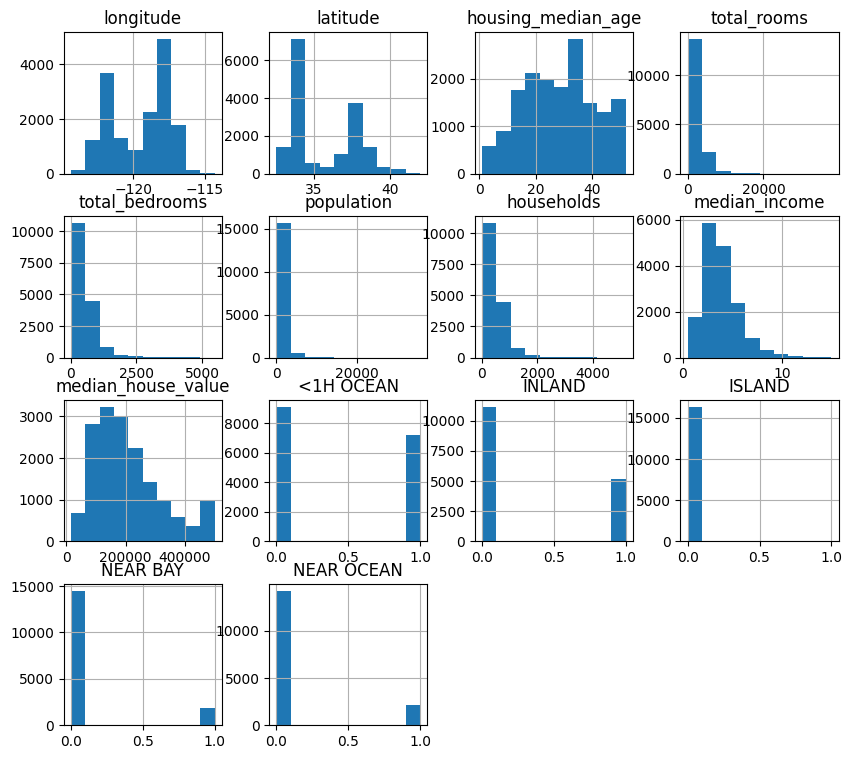

In [8]:
# Original Distribution

df2.hist(figsize=(10, 9));

In [9]:
# Applying logarithm

df2['total_rooms'] = np.log1p(df2['total_rooms'])
df2['total_bedrooms'] = np.log1p(df2['total_bedrooms'])
df2['population'] = np.log1p(df2['population'])
df2['households'] = np.log1p(df2['households'])

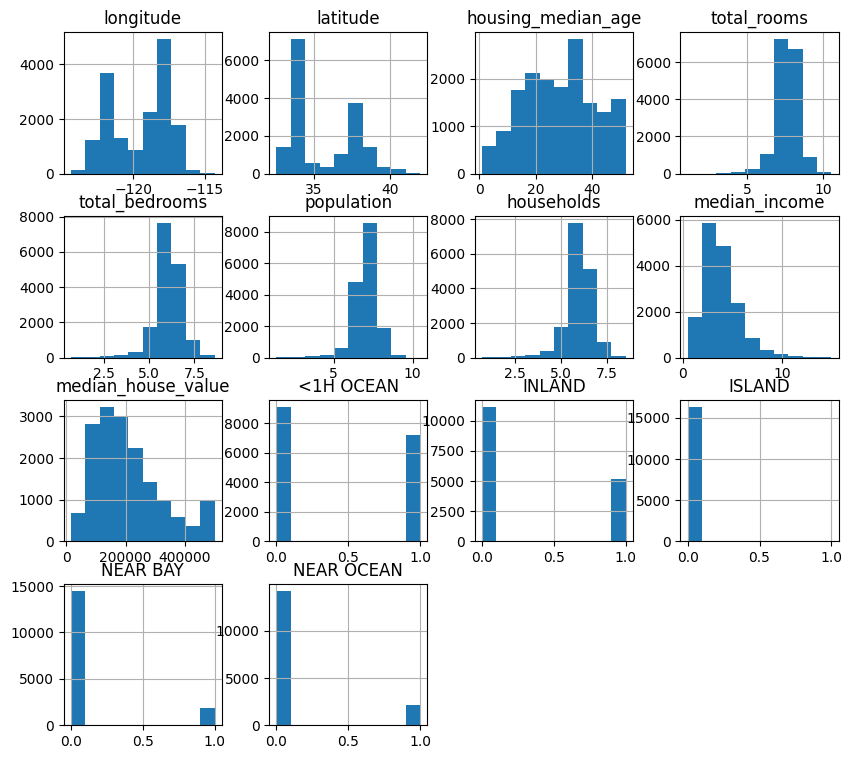

In [10]:
# Distribution after applying logarithm

df2.hist(figsize=(10, 9));

# EXPLORATORY DATA ANALYSIS

In [11]:
df3 = df2.copy()

#### Are older houses more expensive?
There is no significant variation in value in relation to the age of the houses.

Text(0.5, 1.0, 'Relationship between age and average house value')

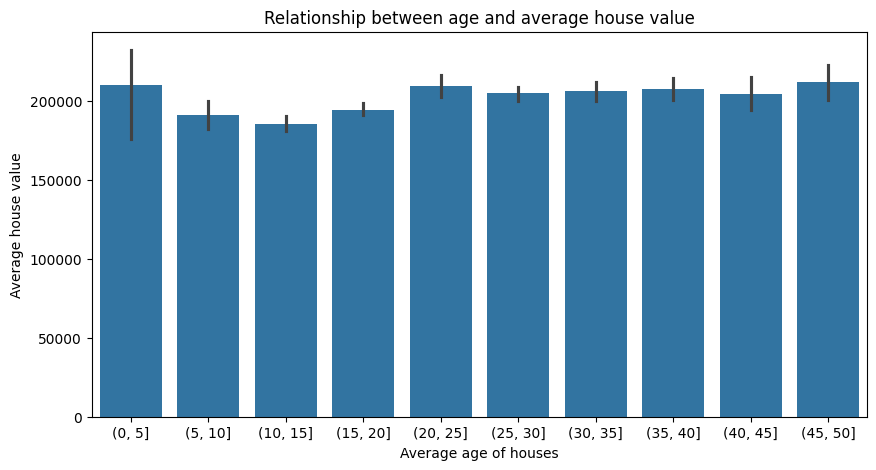

In [12]:
df_aux = df3[['housing_median_age', 'median_house_value']].groupby('housing_median_age').mean().sort_values('median_house_value', ascending=False).reset_index()
df_aux['housing_median_age_binned'] = pd.cut(df_aux['housing_median_age'], bins= np.arange(0,52,5))

df_aux = df_aux[['housing_median_age_binned', 'median_house_value']]

plt.figure(figsize=(10,5))
sns.barplot(x= df_aux['housing_median_age_binned'], y= df_aux['median_house_value'])
plt.xlabel('Average age of houses')
plt.ylabel('Average house value')
plt.title('Relationship between age and average house value')

#### Houses close to the coast are more expensive?
Yes, the most expensive houses are concentrated on the coast.

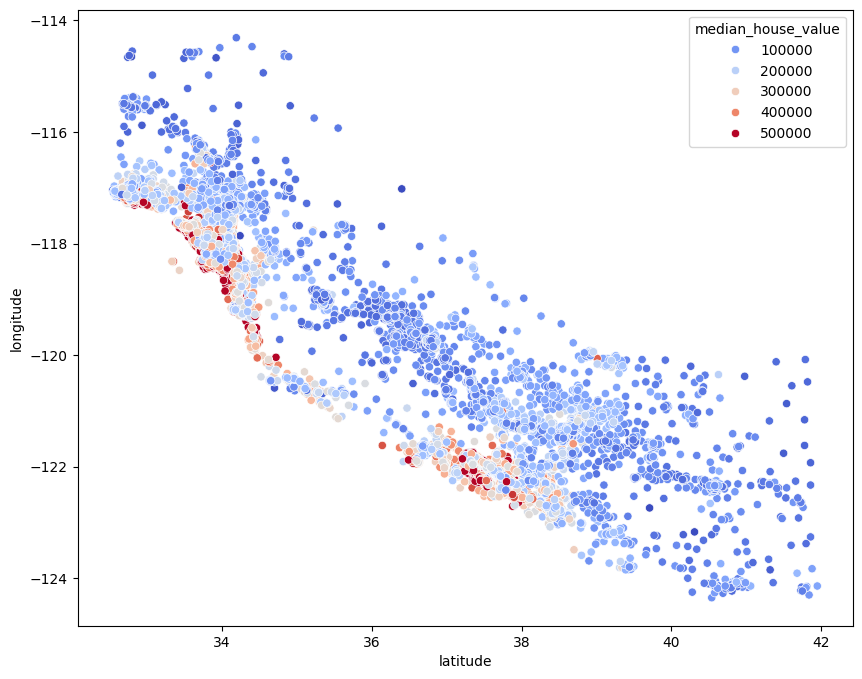

In [13]:
plt.figure(figsize=(10,8))
sns.scatterplot(x='latitude', y='longitude', data=df3, hue='median_house_value', palette='coolwarm');


#### Are areas with more expensive homes less populated?
Not necessarily. The most populated area is the second with the most expensive houses

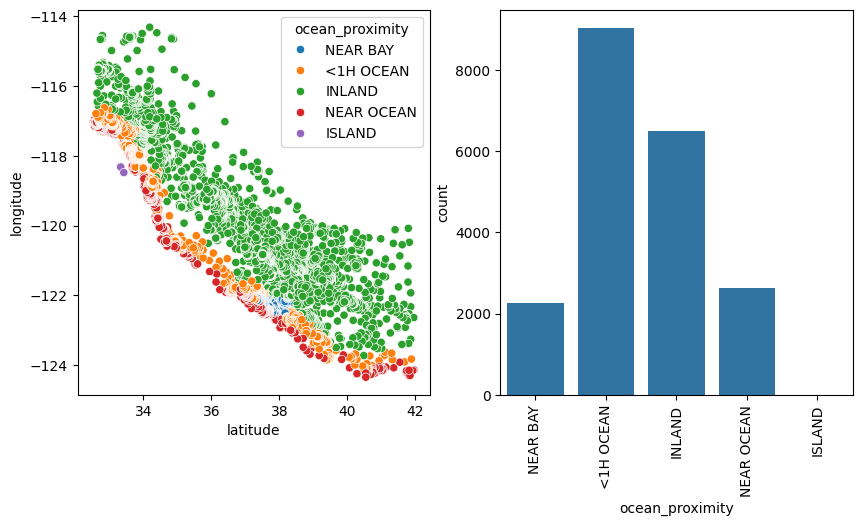

In [14]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
sns.scatterplot(x='latitude', y='longitude', data=df1, hue='ocean_proximity')

plt.subplot(1,2,2)
sns.countplot(x='ocean_proximity', data=df1)
plt.xticks(rotation=90);


#### The richest don't live near the coast
They live less than 1 hour from the coast


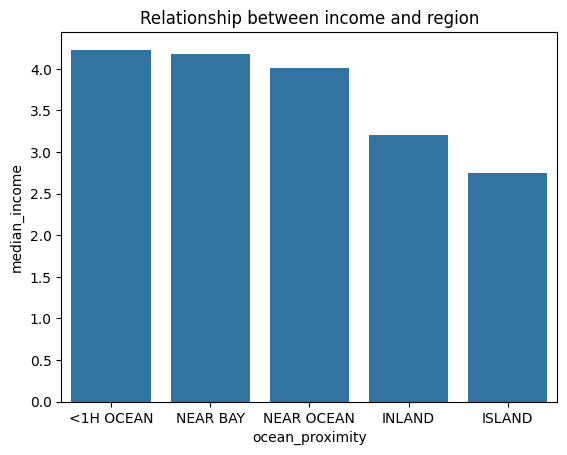

In [15]:
df_aux = df1[['median_income', 'ocean_proximity']].groupby('ocean_proximity').mean().sort_values('median_income', ascending=False).reset_index()
sns.barplot(x='ocean_proximity', y='median_income', data= df_aux)
plt.title('Relationship between income and region');

#### The higher the income, the more expensive the house?
The value of houses increases along with the increase in family income

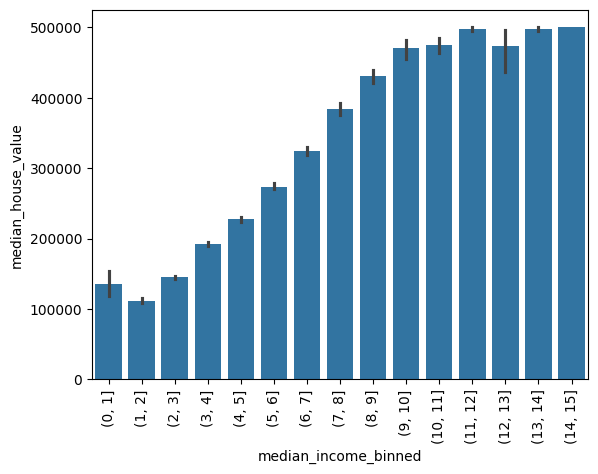

In [16]:
df_aux = df3
median_income_binned = pd.cut(df3['median_income'], bins= np.arange(0,16,1))
df_aux['median_income_binned'] = median_income_binned 

sns.barplot(x='median_income_binned', y='median_house_value', data=df_aux)
plt.xticks(rotation=90);

#### House prices by region

<BarContainer object of 5 artists>

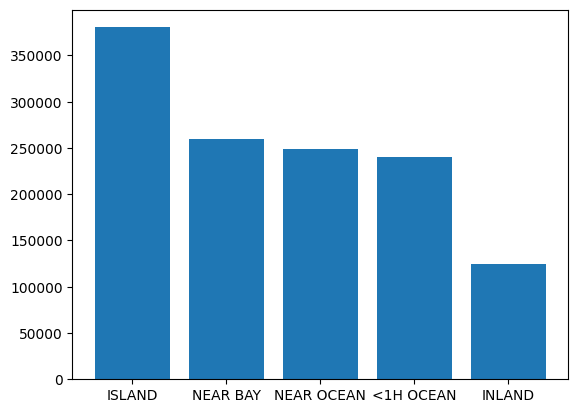

In [17]:
# Average house price by region

df_aux = df1[['median_house_value', 'ocean_proximity']].groupby('ocean_proximity').mean().reset_index().round(2).sort_values('median_house_value', ascending=False)
plt.bar(df_aux['ocean_proximity'], df_aux['median_house_value'])

<BarContainer object of 5 artists>

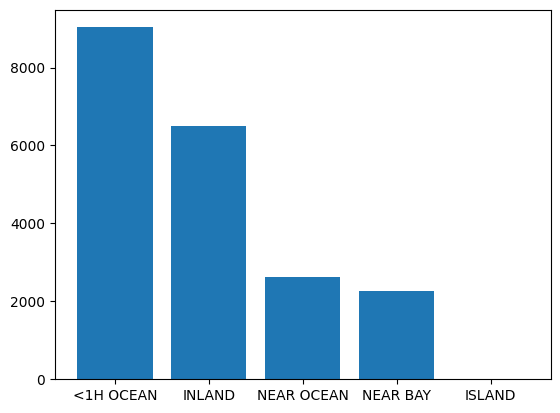

In [18]:
# Number of houses per region

df_aux = df1[['median_house_value', 'ocean_proximity']].groupby('ocean_proximity').count().reset_index().round(2).sort_values('median_house_value', ascending=False)
plt.bar(df_aux['ocean_proximity'], df_aux['median_house_value'])

# HEATMAP

In [19]:
df3.drop(columns=['median_income_binned', 'ISLAND'], inplace=True, axis=1)

<Axes: >

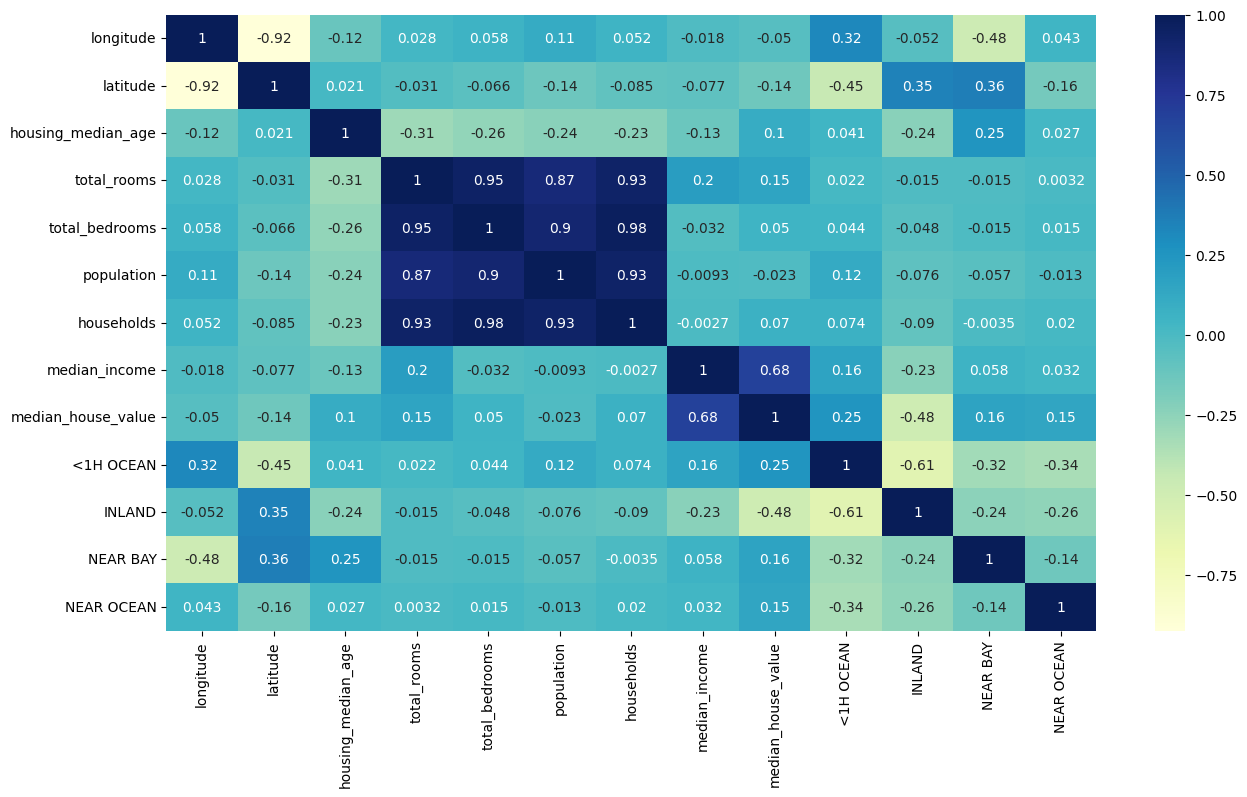

In [20]:
plt.figure(figsize=(15, 8))
sns.heatmap( df3.corr(), annot=True, cmap='YlGnBu' )

# DATA PREPARATION

In [21]:
df4 = df3.copy()

# Rescaling

In [22]:
rs = RobustScaler() # When there are big outliers
mms = MinMaxScaler() # When there are no major outliers

df4['total_rooms'] = rs.fit_transform(df4[['total_rooms']])
df4['total_bedrooms'] = rs.fit_transform(df4[['total_bedrooms']])
df4['population'] = rs.fit_transform(df4[['population']])
df4['households'] = rs.fit_transform(df4[['households']])
df4['median_income'] = rs.fit_transform(df4[['median_income']])

## Response Variable distribution

<Axes: xlabel='median_house_value', ylabel='Count'>

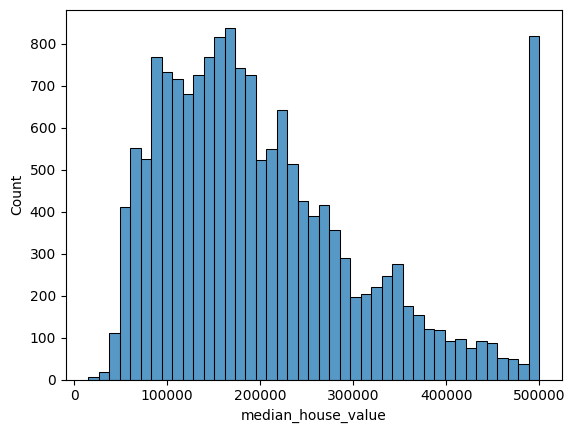

In [23]:
sns.histplot(df4['median_house_value'])

## Applying the same feature engineering to test data

In [24]:
test_data = pd.concat([x_test, y_test], axis=1)

test_data = pd.concat([test_data, pd.get_dummies(test_data['ocean_proximity']).astype(int)], axis=1)
test_data = test_data.drop(['ocean_proximity'], axis=1)

test_data['total_rooms'] = np.log1p(test_data['total_rooms'])
test_data['total_bedrooms'] = np.log1p(test_data['total_bedrooms'])
test_data['population'] = np.log1p(test_data['population'])
test_data['households'] = np.log1p(test_data['households'])

In [25]:
x_train, y_train = df3.drop(['median_house_value'], axis=1), df3['median_house_value']
x_test, y_test = test_data .drop(['median_house_value'], axis=1), test_data ['median_house_value']

# Machine Learning

## Creating a table for performance comparison

In [26]:
def mean_absolute_percentage_error(y, yhat):
    return np.mean( np.abs( (y - yhat) / y ) )

In [27]:
def ml_error(model_name, y, yhat, score):
    mae = mean_absolute_error(y, yhat).round(2)
    mape = mean_absolute_percentage_error(y, yhat).round(2)
    rmse = np.sqrt(mean_squared_error(y, yhat)).round(2)
    
    return pd.DataFrame({'Model Name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RMSE': rmse,
                         'SCORE': score}, index=[0])

## Linear Regression

In [28]:
linear_model = LinearRegression()

# training and predict
linear_model.fit(x_train, y_train)
y_hat = linear_model.predict(x_test)

score = linear_model.score(x_test, y_test)

# Performance
linear_result = ml_error('Linear Model', y_test, y_hat, score)
linear_result

,Model Name,MAE,MAPE,RMSE,SCORE
0,Linear Model,47410.2,0.28,65742.63,0.682556


## Random Forest

In [29]:
# Define
forest = RandomForestRegressor()

# Training
forest.fit(x_train, y_train)
y_hat_forest = forest.predict(x_test)

score = forest.score(x_test, y_test)

# Performance
random_forest_result = ml_error('Random Forest', y_test, y_hat_forest, score)
random_forest_result

,Model Name,MAE,MAPE,RMSE,SCORE
0,Random Forest,30485.48,0.17,46892.82,0.838495


### Random Forest Best Grid

In [30]:
param_grid = {'n_estimators': list(range(100,500,50)),
              'max_depth': [None, 10, 20, 30],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4]
              }

# Define
forest = RandomForestRegressor()
forest_best_param = RandomizedSearchCV(forest, param_grid, n_iter=5, cv=3, verbose=2, random_state=42)

# Training
forest_best_param.fit(x_train, y_train)
forest_best_param.best_estimator_


Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=350; total time=  26.4s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=350; total time=  24.4s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=350; total time=  23.1s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=350; total time=  25.8s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=350; total time=  28.0s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=350; total time=  25.6s
[CV] END max_depth=30, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   6.6s
[CV] END max_depth=30, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   6.6s
[CV] END max_depth=30, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   6.6s
[CV] END max_depth=

RandomForestRegressor(max_depth=20, min_samples_leaf=2, min_samples_split=5,
                      n_estimators=350)

In [31]:
y_hat_forest_best_param = forest_best_param.predict(x_test)

score = forest_best_param.score(x_test, y_test)

# Performance
forest_best_param_result = ml_error('Random Forest Best param', y_test, y_hat_forest_best_param, score)
forest_best_param_result

,Model Name,MAE,MAPE,RMSE,SCORE
0,Random Forest Best param,30172.15,0.17,46466.93,0.841416


## XGBoost

In [32]:
# To change feature name to xgboost pattern
x_train = x_train.rename(columns={'<1H OCEAN': 'LESS 1H OCEAN'})
x_test = x_test.rename(columns={'<1H OCEAN': 'LESS 1H OCEAN'})

# Define
model_xgb = xgb.XGBRegressor(max_depth=10, subsample=0.7)

# Training
model_xgb.fit(x_train, y_train)
xgb_hat = model_xgb.predict(x_test)

score = model_xgb.score(x_test, y_test)

# Performance
xgb_result = ml_error('XGBoost', y_test, xgb_hat, score)
xgb_result

,Model Name,MAE,MAPE,RMSE,SCORE
0,XGBoost,31435.73,0.18,48276.56,0.828823


## Ensemble Model

In [33]:
ensemble_mean = (y_hat + y_hat_forest_best_param + xgb_hat) / 3
ensemble_result = ml_error('Ensemble', y_test, ensemble_mean, score )

## Models comparison

In [34]:
modelling_result = pd.concat([linear_result, forest_best_param_result, xgb_result, ensemble_result]).sort_values('RMSE')
modelling_result

,Model Name,MAE,MAPE,RMSE,SCORE
0,Random Forest Best param,30172.15,0.17,46466.93,0.841416
0,Ensemble,32081.90,0.18,48193.60,0.828823
0,XGBoost,31435.73,0.18,48276.56,0.828823
0,Linear Model,47410.20,0.28,65742.63,0.682556
